# BigTable MTLM - dataset perplexity testing

Aim of this notebook:
1. Generate student + question datasets
2. Generate N sets of encounters
3. Report on agreement between these sets

The error between the datasets (for large N) is the inherent probabilistic error in the model
- How does this translate to tolerances in the $\alpha$ and $\delta$ parameters

## Model perplexity
A model $q$ is used to predict the values of a set of samples, $\mathbf{x}$.  Perplexity is defined as:

\\[{perplex}_{q}(\mathbf{x}) = b^{-\frac{1}{N}\Sigma_{i=1}^{N}{log_{b}(q(x_i))}}\\]

Perplexity is a measure of `surprise' as a divergence from the predictions that are seen in the true values.


In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name, create_qs, create_students, generate_attempts, calculate_pass_probability, attempt_q

import random

from matplotlib import pyplot as plt

# p = 1 / (1 + e^-z)
# -ln((1/ p) - 1) = z
-log((1/0.993) - 1)

from scipy.optimize import curve_fit
def gompertz(x, A,k1,k2,off):
    return A*numpy.exp(-k1*numpy.exp(-k2*(x-off)))

def inv_gompertz(y, A,k1,k2,off):
    return off + numpy.log(k1/numpy.log(A/y))/k2

def logistic(x, b,off):
    return 1/(1+(numpy.exp(-b*(x-off))))

# p = 1/(1+e(-x))
# 1+e(-x) = 1/p
# e(-x) = (1/p)-1
# x = -log((1/p)-1)

def inv_logistic(pr, b,off):
    return off-(numpy.log((1/pr) -1))/b

Using TensorFlow backend.


In [2]:
sigmoid = lambda z: 1/(1+(numpy.exp(-z)))
def pr(a,d): return sigmoid((a-d))
def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/comps)
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

In [76]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_students(n_students, a0, a1, n_factors, gen_mode="truncnorm"):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.repeat(3, n_factors)
        if gen_mode=="truncnorm":
            true_comps = numpy.random.normal(a0, a1, size=n_factors)
            true_comps = numpy.clip(true_comps,6,12)
        elif gen_mode=="uniform":
            clip0 = a0 - a1*3
            clip1 = a0 + a1*3
            true_comps = numpy.random.uniform(clip0, clip1, size=n_factors)
        else:
            print("unknown distro mode")
        print("True comps", a0,a1, true_comps)
#         true_comps = numpy.random.uniform(a0-3*a1, a0+3*a1, size=n_factors)
#         true_comps = numpy.repeat(3, n_factors)
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c
    return students

def gen_questions(n_questions, a0, a1, min_active_traits, max_active_traits, gen_mode="truncnorm"):
    #approximate the min and max outputs from the gaussian
    inv_fn = spread_to_pr
    av_c = (min_active_traits + max_active_traits)/2
    p = numpy.linspace(0.001,0.999,30)
    sprd = pr_to_spread(p, av_c, as_A_and_D=False)
#     plt.scatter(sprd,p)
#     plt.show()
#     popt, pcov = curve_fit(inv_fn, p, sprd)
#     print(popt)
#     p = numpy.linspace(0.001,0.999,50)
#     d = (p, comps=av_c)
    p2 = spread_to_pr(sprd, av_c)
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    d99 = pr_to_spread(.999, av_c, as_A_and_D=False)
    d00 = pr_to_spread(.001, av_c, as_A_and_D=False)
    print("dvals", d00, d50, d99)
    print("inv_logistic curve")
    plt.scatter(sprd,p)
    plt.plot(sprd,p2)
    plt.show()
    print("tru spread d50=",d50, "(prob={})".format(spread_to_pr(d50, av_c)))
    
    minval = math.inf
    
    questions = numpy.zeros((n_questions, n_factors))
    for qix in range(n_questions):
        n_comps = random_integers(min_active_traits, max_active_traits)
        print("NCOMPS", n_comps)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
        
        mu = a0
        sd = a1
        clip_a, clip_b = 0.0001,0.9999
#         a, b = (clip_a - mu) / sd, (clip_b - mu) / sd
#         standard_probs = scipy.stats.norm.rvs(loc=.5, scale=1/6, size=n_comps)
        if gen_mode == "u_uniform":
#             true_comps = numpy.random.uniform((mu-3*sd)-d99, (mu+3*sd)-d00, size=n_comps)
            true_comps = numpy.random.uniform(mu-d99, mu-d00, size=n_comps)
#             print("true q comps", true_comps)
        elif gen_mode == "c50":
            true_comps = numpy.repeat(mu-d50, n_comps)
        else:
            standard_probs=[]
            if gen_mode == "truncnorm":
                standard_probs = numpy.random.normal(loc=0.5, scale=1/6, size=n_comps)
                standard_probs = numpy.clip(standard_probs,clip_a,clip_b)
            elif gen_mode == "beta22":
                standard_probs = numpy.random.beta(2,2, size=n_comps)# normal(loc=.5, scale=1/6, size=n_comps)
    #         standard_probs = truncnorm.rvs(clip_a, clip_b, loc=mu, scale=sd, size=n_comps)
            elif gen_mode == "uniform":
                standard_probs = numpy.random.uniform(clip_a, clip_b, size=n_comps)
#         standard_probs = numpy.repeat(0.5, n_comps)
            true_comps = a0 - pr_to_spread(standard_probs, comps=n_comps, as_A_and_D=False)
            print(standard_probs,"-->",true_comps)
        
        this_min = min(true_comps)
        if this_min < minval:
            minval= this_min
        
#         plt.scatter(true_comps, standard_probs)
#         plt.show()
                
#         print("Q comps", true_comps)
        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c
            
        print("q minval is", minval)
        for cix,c in zip(comp_ixs,true_comps):
            if questions[qix,cix] !=0:
                questions[qix,cix] = questions[qix,cix]# - minval + 1
    return questions, minval

# minb,maxb,mina,maxa =(1.0, 11, 6, 11)
def gen_run(n_traits, a0, a1, min_active_traits, max_active_traits, q_gen="uniform"):
    students = gen_students(n_students, a0, a1, n_factors)
    questions, offset = gen_questions(n_questions, a0, a1, min_active_traits, max_active_traits, gen_mode=q_gen)

    questions[questions>0] = questions[questions>0] - offset+6
    students = students - offset+6
    
    sig = lambda z : 1/(1+numpy.exp(-z))
    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    #obs = numpy.matmul(viewers, movies.T)/n_factors
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
            zmask = (questions[mi]==0).astype(int)
            deltas = students[vi]-questions[mi]
            prs = sig(deltas)
            prs = numpy.maximum(zmask,prs)

#             print(vi,mi)
#             print("S", students[vi])
#             print("Q", questions[mi])
#             print("Z", zmask)
#             print("D", deltas)
#             print("p", prs)
#             print("P", numpy.prod(prs))
            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = numpy.prod(prs)
#             print(vi,mi, numpy.prod(prs))
    return obs, probs, students, questions

>>> 1
True comps [ 1.72131703]
True comps [ 4.26785616]
True comps [ 3.33815593]
True comps [ 4.06720223]
True comps [ 1.01216218]
True comps [ 2.95218224]
True comps [ 3.26348808]
True comps [ 3.20230055]
True comps [ 6.]
True comps [ 4.40930866]
True comps [ 4.0891295]
True comps [ 4.63000765]
True comps [ 4.33699029]
True comps [ 2.8977428]
True comps [ 4.24647705]
True comps [ 3.89689312]
True comps [ 3.6151722]
True comps [ 3.25833026]
True comps [ 4.94730561]
True comps [ 3.50332909]
True comps [ 1.00694603]
True comps [ 3.69342554]
True comps [ 3.65641976]
True comps [ 3.04548863]
True comps [ 3.54299418]
True comps [ 2.82818486]
True comps [ 2.33913788]
True comps [ 1.43411322]
True comps [ 3.8682475]
True comps [ 2.02929465]
True comps [ 2.17638831]
True comps [ 2.1274256]
True comps [ 1.33353043]
True comps [ 5.07252635]
True comps [ 3.24528182]
True comps [ 2.63482729]
True comps [ 0.99952309]
True comps [ 3.16217924]
True comps [ 4.62830995]
True comps [ 2.84413123]
True co

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


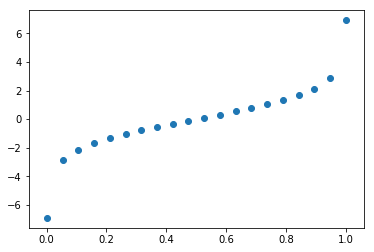

d50= -2.18114415418e-12
[ 0.74325755] --> [ 4.06296917]
[ 0.03060863] --> [-0.45538642]
[ 0.21703478] --> [ 1.71696937]
[ 0.94623554] --> [ 5.86787883]
[ 0.28567718] --> [ 2.08352743]
[ 0.53708845] --> [ 3.14862679]
[ 0.80904011] --> [ 4.44378511]
[ 0.33781384] --> [ 2.32694824]
[ 0.27943962] --> [ 2.052757]
[ 0.69662906] --> [ 3.83129681]
0 0
S [ 1.72131703]
Q [ 4.06296917]
Z [0]
D [-2.34165213]
p [ 0.0877316]
P 0.0877315966669
0 1
S [ 1.72131703]
Q [-0.45538642]
Z [0]
D [ 2.17670346]
p [ 0.89813788]
P 0.898137879503
0 2
S [ 1.72131703]
Q [ 1.71696937]
Z [0]
D [ 0.00434767]
p [ 0.50108691]
P 0.501086914842
0 3
S [ 1.72131703]
Q [ 5.86787883]
Z [0]
D [-4.1465618]
p [ 0.01557238]
P 0.0155723761347
0 4
S [ 1.72131703]
Q [ 2.08352743]
Z [0]
D [-0.3622104]
p [ 0.4104246]
P 0.41042459612
0 5
S [ 1.72131703]
Q [ 3.14862679]
Z [0]
D [-1.42730976]
p [ 0.1935182]
P 0.193518201042
0 6
S [ 1.72131703]
Q [ 4.44378511]
Z [0]
D [-2.72246807]
p [ 0.06166051]
P 0.0616605126132
0 7
S [ 1.72131703]
Q [ 

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: This function is deprecated. Please call randint(1, 1 + 1) instead


Z [0]
D [-3.05080699]
p [ 0.04518265]
P 0.0451826463809
4 1
S [ 1.01216218]
Q [-0.45538642]
Z [0]
D [ 1.46754861]
p [ 0.8126845]
P 0.812684500116
4 2
S [ 1.01216218]
Q [ 1.71696937]
Z [0]
D [-0.70480719]
p [ 0.33074728]
P 0.330747275707
4 3
S [ 1.01216218]
Q [ 5.86787883]
Z [0]
D [-4.85571665]
p [ 0.00772363]
P 0.00772363427445
4 4
S [ 1.01216218]
Q [ 2.08352743]
Z [0]
D [-1.07136525]
p [ 0.25514354]
P 0.255143537652
4 5
S [ 1.01216218]
Q [ 3.14862679]
Z [0]
D [-2.13646461]
p [ 0.10560284]
P 0.105602844734
4 6
S [ 1.01216218]
Q [ 4.44378511]
Z [0]
D [-3.43162293]
p [ 0.03132165]
P 0.0313216541713
4 7
S [ 1.01216218]
Q [ 2.32694824]
Z [0]
D [-1.31478606]
p [ 0.21168707]
P 0.21168706567
4 8
S [ 1.01216218]
Q [ 2.052757]
Z [0]
D [-1.04059482]
p [ 0.26103524]
P 0.261035238988
4 9
S [ 1.01216218]
Q [ 3.83129681]
Z [0]
D [-2.81913463]
p [ 0.05629889]
P 0.0562988925068
5 0
S [ 2.95218224]
Q [ 4.06296917]
Z [0]
D [-1.11078692]
p [ 0.24772421]
P 0.247724211102
5 1
S [ 2.95218224]
Q [-0.45538642

Q [ 2.08352743]
Z [0]
D [ 1.81336569]
p [ 0.85976816]
P 0.859768156316
15 5
S [ 3.89689312]
Q [ 3.14862679]
Z [0]
D [ 0.74826633]
p [ 0.67880082]
P 0.678800823474
15 6
S [ 3.89689312]
Q [ 4.44378511]
Z [0]
D [-0.54689199]
p [ 0.36658579]
P 0.366585791885
15 7
S [ 3.89689312]
Q [ 2.32694824]
Z [0]
D [ 1.56994488]
p [ 0.82777575]
P 0.827775750802
15 8
S [ 3.89689312]
Q [ 2.052757]
Z [0]
D [ 1.84413612]
p [ 0.86343714]
P 0.863437144942
15 9
S [ 3.89689312]
Q [ 3.83129681]
Z [0]
D [ 0.06559631]
p [ 0.5163932]
P 0.516393200101
16 0
S [ 3.6151722]
Q [ 4.06296917]
Z [0]
D [-0.44779696]
p [ 0.38988469]
P 0.389884685326
16 1
S [ 3.6151722]
Q [-0.45538642]
Z [0]
D [ 4.07055863]
p [ 0.98321857]
P 0.98321857166
16 2
S [ 3.6151722]
Q [ 1.71696937]
Z [0]
D [ 1.89820284]
p [ 0.86968799]
P 0.869687986916
16 3
S [ 3.6151722]
Q [ 5.86787883]
Z [0]
D [-2.25270663]
p [ 0.09511625]
P 0.0951162524849
16 4
S [ 3.6151722]
Q [ 2.08352743]
Z [0]
D [ 1.53164477]
p [ 0.82224684]
P 0.822246836349
16 5
S [ 3.615172

Q [ 3.83129681]
Z [0]
D [-0.28830263]
p [ 0.42841946]
P 0.428419461732
25 0
S [ 2.82818486]
Q [ 4.06296917]
Z [0]
D [-1.2347843]
p [ 0.22534516]
P 0.225345157626
25 1
S [ 2.82818486]
Q [-0.45538642]
Z [0]
D [ 3.28357129]
p [ 0.96386089]
P 0.963860888797
25 2
S [ 2.82818486]
Q [ 1.71696937]
Z [0]
D [ 1.11121549]
p [ 0.75235565]
P 0.752355647703
25 3
S [ 2.82818486]
Q [ 5.86787883]
Z [0]
D [-3.03969397]
p [ 0.04566451]
P 0.0456645055944
25 4
S [ 2.82818486]
Q [ 2.08352743]
Z [0]
D [ 0.74465743]
p [ 0.67801347]
P 0.678013466995
25 5
S [ 2.82818486]
Q [ 3.14862679]
Z [0]
D [-0.32044193]
p [ 0.42056805]
P 0.420568049664
25 6
S [ 2.82818486]
Q [ 4.44378511]
Z [0]
D [-1.61560025]
p [ 0.16581254]
P 0.16581254413
25 7
S [ 2.82818486]
Q [ 2.32694824]
Z [0]
D [ 0.50123662]
p [ 0.6227499]
P 0.62274989843
25 8
S [ 2.82818486]
Q [ 2.052757]
Z [0]
D [ 0.77542786]
p [ 0.68469388]
P 0.68469387743
25 9
S [ 2.82818486]
Q [ 3.83129681]
Z [0]
D [-1.00311195]
p [ 0.26833002]
P 0.268330015421
26 0
S [ 2.3391

D [ 1.45490952]
p [ 0.81075286]
P 0.810752863775
36 2
S [ 0.99952309]
Q [ 1.71696937]
Z [0]
D [-0.71744627]
p [ 0.32795558]
P 0.327955578382
36 3
S [ 0.99952309]
Q [ 5.86787883]
Z [0]
D [-4.86835574]
p [ 0.00762737]
P 0.00762736880042
36 4
S [ 0.99952309]
Q [ 2.08352743]
Z [0]
D [-1.08400434]
p [ 0.25274898]
P 0.252748980742
36 5
S [ 0.99952309]
Q [ 3.14862679]
Z [0]
D [-2.1491037]
p [ 0.10441501]
P 0.104415008692
36 6
S [ 0.99952309]
Q [ 4.44378511]
Z [0]
D [-3.44426202]
p [ 0.03094044]
P 0.0309404398261
36 7
S [ 0.99952309]
Q [ 2.32694824]
Z [0]
D [-1.32742514]
p [ 0.2095856]
P 0.209585595433
36 8
S [ 0.99952309]
Q [ 2.052757]
Z [0]
D [-1.05323391]
p [ 0.25860459]
P 0.258604585168
36 9
S [ 0.99952309]
Q [ 3.83129681]
Z [0]
D [-2.83177372]
p [ 0.05563114]
P 0.0556311399124
37 0
S [ 3.16217924]
Q [ 4.06296917]
Z [0]
D [-0.90078993]
p [ 0.28888819]
P 0.28888819405
37 1
S [ 3.16217924]
Q [-0.45538642]
Z [0]
D [ 3.61756566]
p [ 0.97385401]
P 0.973854012311
37 2
S [ 3.16217924]
Q [ 1.71696

p [ 0.75218042]
P 0.752180422267
46 9
S [ 3.16303225]
Q [ 3.83129681]
Z [0]
D [-0.66826456]
p [ 0.33888554]
P 0.338885543436
47 0
S [ 2.72853666]
Q [ 4.06296917]
Z [0]
D [-1.33443251]
p [ 0.20842712]
P 0.208427121348
47 1
S [ 2.72853666]
Q [-0.45538642]
Z [0]
D [ 3.18392308]
p [ 0.96022477]
P 0.960224771752
47 2
S [ 2.72853666]
Q [ 1.71696937]
Z [0]
D [ 1.01156729]
p [ 0.73332676]
P 0.733326758309
47 3
S [ 2.72853666]
Q [ 5.86787883]
Z [0]
D [-3.13934217]
p [ 0.04151329]
P 0.0415132863293
47 4
S [ 2.72853666]
Q [ 2.08352743]
Z [0]
D [ 0.64500922]
p [ 0.65588492]
P 0.65588492311
47 5
S [ 2.72853666]
Q [ 3.14862679]
Z [0]
D [-0.42009014]
p [ 0.39649518]
P 0.396495181668
47 6
S [ 2.72853666]
Q [ 4.44378511]
Z [0]
D [-1.71524845]
p [ 0.15248421]
P 0.152484206082
47 7
S [ 2.72853666]
Q [ 2.32694824]
Z [0]
D [ 0.40158842]
p [ 0.59906924]
P 0.599069235068
47 8
S [ 2.72853666]
Q [ 2.052757]
Z [0]
D [ 0.67577965]
p [ 0.66279611]
P 0.662796110131
47 9
S [ 2.72853666]
Q [ 3.83129681]
Z [0]
D [-1.

p [ 0.92385681]
P 0.923856812175
57 9
S [ 4.54869848]
Q [ 3.83129681]
Z [0]
D [ 0.71740167]
p [ 0.67203459]
P 0.672034590494
58 0
S [ 1.67178347]
Q [ 4.06296917]
Z [0]
D [-2.3911857]
p [ 0.08384731]
P 0.0838473054353
58 1
S [ 1.67178347]
Q [-0.45538642]
Z [0]
D [ 2.1271699]
p [ 0.89351604]
P 0.89351603739
58 2
S [ 1.67178347]
Q [ 1.71696937]
Z [0]
D [-0.0451859]
p [ 0.48870545]
P 0.488705447532
58 3
S [ 1.67178347]
Q [ 5.86787883]
Z [0]
D [-4.19609536]
p [ 0.01483097]
P 0.0148309745299
58 4
S [ 1.67178347]
Q [ 2.08352743]
Z [0]
D [-0.41174396]
p [ 0.39849403]
P 0.398494025587
58 5
S [ 1.67178347]
Q [ 3.14862679]
Z [0]
D [-1.47684332]
p [ 0.18590469]
P 0.185904690411
58 6
S [ 1.67178347]
Q [ 4.44378511]
Z [0]
D [-2.77200164]
p [ 0.05885604]
P 0.0588560408107
58 7
S [ 1.67178347]
Q [ 2.32694824]
Z [0]
D [-0.65516477]
p [ 0.34182661]
P 0.341826614573
58 8
S [ 1.67178347]
Q [ 2.052757]
Z [0]
D [-0.38097353]
p [ 0.40589211]
P 0.405892114611
58 9
S [ 1.67178347]
Q [ 3.83129681]
Z [0]
D [-2.1

Q [ 3.83129681]
Z [0]
D [-0.86148345]
p [ 0.2970295]
P 0.297029502961
70 0
S [ 2.74704684]
Q [ 4.06296917]
Z [0]
D [-1.31592233]
p [ 0.21149751]
P 0.211497511532
70 1
S [ 2.74704684]
Q [-0.45538642]
Z [0]
D [ 3.20243326]
p [ 0.96092574]
P 0.960925742524
70 2
S [ 2.74704684]
Q [ 1.71696937]
Z [0]
D [ 1.03007747]
p [ 0.73693091]
P 0.736930914616
70 3
S [ 2.74704684]
Q [ 5.86787883]
Z [0]
D [-3.12083199]
p [ 0.04225609]
P 0.0422560878519
70 4
S [ 2.74704684]
Q [ 2.08352743]
Z [0]
D [ 0.6635194]
p [ 0.66005053]
P 0.660050530034
70 5
S [ 2.74704684]
Q [ 3.14862679]
Z [0]
D [-0.40157996]
p [ 0.4009328]
P 0.400932797761
70 6
S [ 2.74704684]
Q [ 4.44378511]
Z [0]
D [-1.69673827]
p [ 0.15489175]
P 0.154891745889
70 7
S [ 2.74704684]
Q [ 2.32694824]
Z [0]
D [ 0.4200986]
p [ 0.60350684]
P 0.603506843552
70 8
S [ 2.74704684]
Q [ 2.052757]
Z [0]
D [ 0.69428983]
p [ 0.66692054]
P 0.666920541405
70 9
S [ 2.74704684]
Q [ 3.83129681]
Z [0]
D [-1.08424997]
p [ 0.25270259]
P 0.252702591653
71 0
S [ 1.588

Q [ 2.32694824]
Z [0]
D [ 1.63626229]
p [ 0.8370257]
P 0.837025704283
80 8
S [ 3.96321052]
Q [ 2.052757]
Z [0]
D [ 1.91045352]
p [ 0.87107009]
P 0.871070090116
80 9
S [ 3.96321052]
Q [ 3.83129681]
Z [0]
D [ 0.13191371]
p [ 0.53293069]
P 0.532930689652
81 0
S [ 2.64920189]
Q [ 4.06296917]
Z [0]
D [-1.41376728]
p [ 0.19564054]
P 0.195640538034
81 1
S [ 2.64920189]
Q [-0.45538642]
Z [0]
D [ 3.10458832]
p [ 0.95708161]
P 0.957081612313
81 2
S [ 2.64920189]
Q [ 1.71696937]
Z [0]
D [ 0.93223252]
p [ 0.717528]
P 0.71752799656
81 3
S [ 2.64920189]
Q [ 5.86787883]
Z [0]
D [-3.21867694]
p [ 0.03846889]
P 0.0384688944095
81 4
S [ 2.64920189]
Q [ 2.08352743]
Z [0]
D [ 0.56567446]
p [ 0.63776448]
P 0.637764481066
81 5
S [ 2.64920189]
Q [ 3.14862679]
Z [0]
D [-0.4994249]
p [ 0.37767583]
P 0.377675828561
81 6
S [ 2.64920189]
Q [ 4.44378511]
Z [0]
D [-1.79458322]
p [ 0.14251173]
P 0.142511726404
81 7
S [ 2.64920189]
Q [ 2.32694824]
Z [0]
D [ 0.32225365]
p [ 0.57987339]
P 0.579873386372
81 8
S [ 2.6492

Q [ 2.08352743]
Z [0]
D [-0.58315402]
p [ 0.35820718]
P 0.358207176457
92 5
S [ 1.50037341]
Q [ 3.14862679]
Z [0]
D [-1.64825338]
p [ 0.16134515]
P 0.161345149672
92 6
S [ 1.50037341]
Q [ 4.44378511]
Z [0]
D [-2.9434117]
p [ 0.05004882]
P 0.0500488184281
92 7
S [ 1.50037341]
Q [ 2.32694824]
Z [0]
D [-0.82657483]
p [ 0.30436979]
P 0.304369791624
92 8
S [ 1.50037341]
Q [ 2.052757]
Z [0]
D [-0.55238359]
p [ 0.36531157]
P 0.365311574444
92 9
S [ 1.50037341]
Q [ 3.83129681]
Z [0]
D [-2.3309234]
p [ 0.08859407]
P 0.0885940748966
93 0
S [ 3.19835094]
Q [ 4.06296917]
Z [0]
D [-0.86461822]
p [ 0.29637537]
P 0.2963753705
93 1
S [ 3.19835094]
Q [-0.45538642]
Z [0]
D [ 3.65373737]
p [ 0.97475941]
P 0.974759412455
93 2
S [ 3.19835094]
Q [ 1.71696937]
Z [0]
D [ 1.48138158]
p [ 0.81478117]
P 0.814781168972
93 3
S [ 3.19835094]
Q [ 5.86787883]
Z [0]
D [-2.66952789]
p [ 0.06479557]
P 0.064795571498
93 4
S [ 3.19835094]
Q [ 2.08352743]
Z [0]
D [ 1.11482351]
p [ 0.75302727]
P 0.753027268943
93 5
S [ 3.19

In [82]:
import scipy
from scipy.stats import kstest

n_questions = 10
n_students = 100
n_factors = 1
min_active = 1
max_active = 1

dims_scores = {}
best_probs = {}


for maxi in [20]:
    i=0
    while i < 1:
        a0,a1= 3,1#0.67
        
        i+=1
        print(">>>",i)
        
        obs, probz, students, questions = gen_run(n_factors, a0, a1, min_active, max_active)
        probz = probz.flatten()
#         test_stat = kstest(probz, scipy.stats.beta(2,2).pdf)
#         test_stat = kstest(probz, scipy.stats.uniform().pdf)

        test_stat = kstest(probz, scipy.stats.norm(0.5).pdf)
#         test_stat = [numpy.abs(numpy.mean([(p-0.5) for p in probz]))        ]
        sd = numpy.std(numpy.array(probz))
        
#         print("?",loss,sd)
        print("?", test_stat)
#         if (n_factors not in dims_scores) or (dims_scores[n_factors][0] >= test_stat[0] and dims_scores[n_factors][1]*.66 < sd):
        if (n_factors not in dims_scores) or (dims_scores[n_factors][0] > test_stat[0]):
            print("+++")
            dims_scores[n_factors] = (test_stat[0], sd, a0, a1, min_active, max_active)
            best_probs[n_factors] = probz
            best_run = i-1

True comps [ 2.26184396]
True comps [ 2.38945405]
True comps [ 2.41546902]
True comps [ 1.40485923]
True comps [ 4.04835901]
True comps [ 2.11189401]
True comps [ 3.43110093]
True comps [ 2.29299162]
True comps [ 2.21124515]
True comps [ 2.33872312]
True comps [ 4.49762113]
True comps [ 2.08346387]
True comps [ 3.38521313]
True comps [ 2.1897142]
True comps [ 2.626805]
True comps [ 3.69374821]
True comps [ 1.74350122]
True comps [ 1.02110821]
True comps [ 2.12858583]
True comps [ 3.7754806]
True comps [ 2.21440118]
True comps [ 1.76212226]
True comps [ 3.7771715]
True comps [ 2.18612715]
True comps [ 2.78382462]
True comps [ 3.08352436]
True comps [ 2.04906737]
True comps [ 2.35009705]
True comps [ 2.30431836]
True comps [ 2.55254217]
True comps [ 4.63819433]
True comps [ 1.36405943]
True comps [ 1.55960673]
True comps [ 2.75526072]
True comps [ 2.33368801]
True comps [ 3.31322242]
True comps [ 3.65193985]
True comps [ 2.67057712]
True comps [ 2.76144869]
True comps [ 2.5622159]
True c

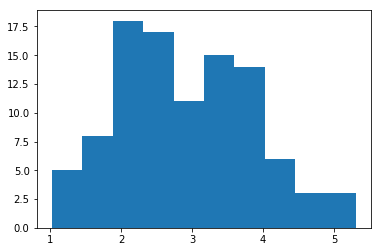

inv_logistic curve


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


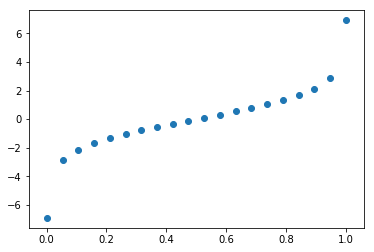

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: This function is deprecated. Please call randint(1, 1 + 1) instead


d50= -2.18114415418e-12
[ 0.90536826] --> [ 5.25834881]
[ 0.83869743] --> [ 4.64856812]
[ 0.48561064] --> [ 2.94242665]
[ 0.39930434] --> [ 2.59163547]
[ 0.22314788] --> [ 1.7525847]
[ 0.56782841] --> [ 3.27299658]
[ 0.48485444] --> [ 2.93939923]
[ 0.83865163] --> [ 4.64822962]
[ 0.56515078] --> [ 3.26209321]
[ 0.91478348] --> [ 5.37349206]
[ 5.37349206] [ 1.7525847]
[[ 5.25834881]
 [ 4.64856812]
 [ 2.94242665]
 [ 2.59163547]
 [ 1.7525847 ]
 [ 3.27299658]
 [ 2.93939923]
 [ 4.64822962]
 [ 3.26209321]
 [ 5.37349206]]


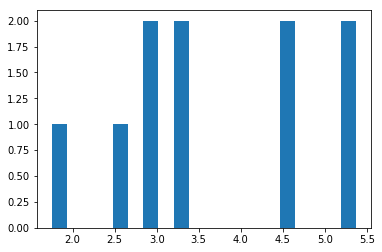

In [85]:
students = gen_students(n_students, a0, a1, n_factors)
all_alphas = students.flatten()
plt.hist(all_alphas, bins=10)
plt.show()

# all_deltas = questions.flatten()
all_deltas = gen_questions(n_questions, a0, a1, min_active, max_act)
print(max(all_deltas), min(all_deltas))
print(all_deltas)
plt.hist(all_deltas, bins=20)
plt.show()

0
1 (0.64765870421212735, 0.31452532865484434, 3, 1, 1, 1)


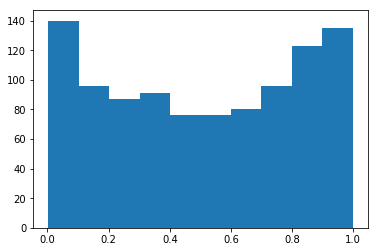

(1, 3, 1, 1, 1)


In [84]:
from IPython.display import clear_output

clear_output()
for dim in dims_scores:
    print(best_run)
    tup = dims_scores[dim]
    print(dim, tup)
    
#     print(best_probs[dim])
    
    probs = best_probs[dim]
    plt.hist(probs)
    plt.show()
    
    
    (loss, sd, a0, a1, min_act, max_act) = tup
    #print((offset+minb, offset+maxb, offset+mu_th-3.0*sd_th, offset+mu_th+3.0*sd_th))
    offset = 0#1-min(mind,maxd)
    print((n_factors, a0, a1, min_act, max_act))

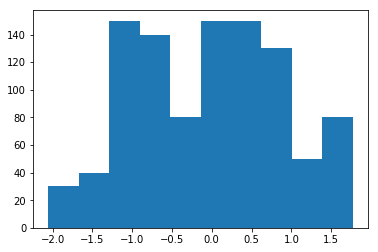

In [53]:
underlying = [pr_to_spread(p, comps=(min_active+max_active)/2, as_A_and_D=False) for p in probs]
plt.hist(underlying)
plt.show()

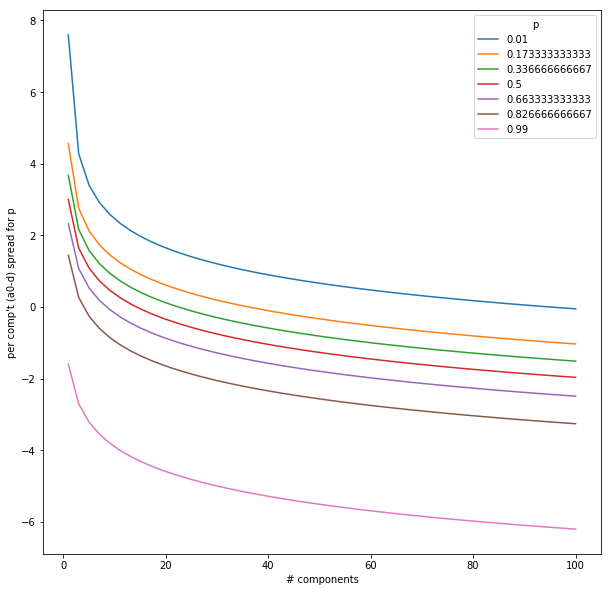

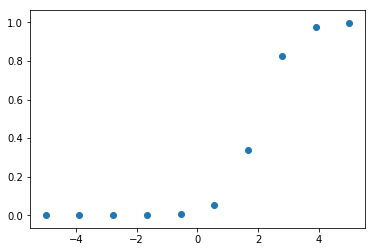

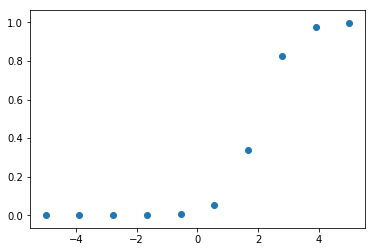

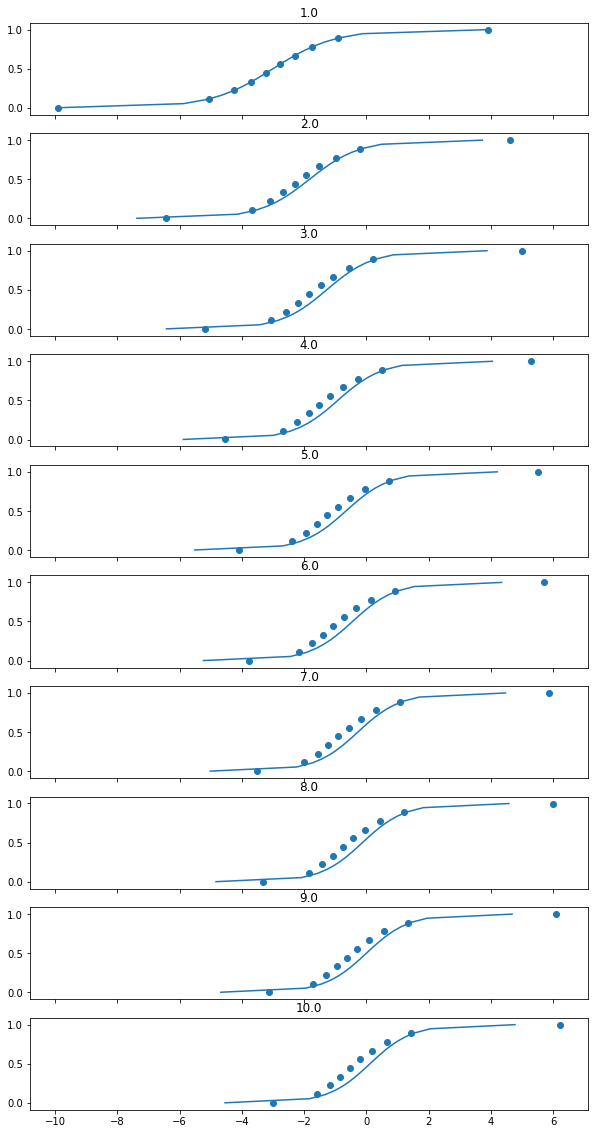

In [166]:
d0 = 6
numpy.set_printoptions(precision=2)

# fig,axes = plt.subplots(11,1, sharex=True)
fig = plt.gcf()
fig.set_size_inches(10,10)
w=100

p01=0.01
p25=0.25
p50=0.5
p75=0.75
p99=0.99
for p in numpy.linspace(0.01,0.99,7):
    x=[]
    y=[]
    for n_comps in numpy.linspace(1,100,50):
        spd = pr_to_spread(p, n_comps, as_A_and_D=False)
        x.append(n_comps)
        y.append(3-spd)
#     print(a-d)
    plt.plot(x, y, label=p)
    plt.xlabel("# components")
    plt.ylabel("per comp't (a0-d) spread for p")
plt.legend(title="p")
plt.show()

fn = logistic
inv_fn = inv_logistic

x = numpy.linspace(-5,5,10)
y = fn(x, 2,2)#,1,0)
plt.scatter(x,y)
plt.show()

back_to_x = inv_fn(y, 2,2)#,1,0)
plt.scatter(back_to_x, y)
plt.show()

# popt, pcov = curve_fit(gompertz, numpy.array(x),numpy.array(y))
# print(popt)
# x2 = numpy.linspace(-5,5,30)
# y2 = gompertz(x2, *popt)
# plt.plot(x2,y2)


fig,axes = plt.subplots(10,1, sharex=True)
fig.set_size_inches(10,20)
axix=0
a0 = 3
for n_comps in numpy.linspace(1,10,10):
    x=[]
    y=[]
    for p in numpy.linspace(0.001,0.999,10):
        sprd = pr_to_spread(p, n_comps, as_A_and_D=False)
        d = a0 - sprd
        x.append(p)
        y.append(-d)
    popt, pcov = curve_fit(inv_fn, numpy.array(x),numpy.array(y))
    p = numpy.linspace(0.001,0.999,20)
    d = inv_fn(p, *popt)
    axes[axix].plot(d,p)        
    axes[axix].scatter(y,x)
    axes[axix].set_title(n_comps)
    axix+=1
plt.show()

In [ ]:
pts=[]
n_comps=1
for p in numpy.random.beta(2,2, size=100):
    a,d = pr_to_spread(p, n_comps)
    print(a,d)
print(numpy.mean(pts))